First install all the necessary dependencies:

In [1]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install Image
!pip install imageio
import PIL.Image

  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


In [2]:
import os
import shutil

In [3]:
%%capture
import random
import numpy as np
import pandas as pd
import numpy.random as rng
import matplotlib.pyplot as plt

In [4]:
import imageio

In [5]:
if os.path.exists('./Adam-experiments'):
    os.chdir('./Adam-experiments')
if os.path.exists('./data/cars'):
    os.chdir('./data/cars/')
!ls

annots.csv  car_ims  car_ims.tgz  cars_annos.mat  models  tmp


In [ ]:
# Look at several images from the training set
annots = pd.read_csv('annots.csv')

# Get subset belonging to a random class 
rand_cl = rng.choice(196)
subset = annots.loc[annots['class']==rand_cl]

fig=plt.figure(figsize=(18, 9))
columns = 2
rows = 2

tr_fn = np.array(subset.loc[:8145].sample(n=columns*rows)['fname'])

for i in range(1, columns*rows +1):
    img = imageio.imread(tr_fn[i-1])    
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
    
plt.show()

In [ ]:
# Look at several images from the validation set
# Make sure it looks like the same class
# But none of the images should be exactly the same

fig=plt.figure(figsize=(18, 9))
columns = 2
rows = 2

val_fn = np.array(subset.loc[8145:].sample(n=columns*rows)['fname'])

for i in range(1, columns*rows +1):
    img = imageio.imread(val_fn[i-1])    
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
    
plt.show()

In [6]:
%%capture

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
#import skimage

In [7]:
if not os.path.exists('data'):
    os.chdir('../..')
!ls

callbacks.py	      lm_val_fns.py    README.md	 utils.py
data		      logs__0.txt      train_cifar10.py
fit_stanford_cars.py  prepare_data.py  train_model.py
get_data.sh	      __pycache__      train_rnn.py


In [8]:
PATH = Path("data/cars/")
val_idxs = list(range(8144, 16185))

def get_data(sz, val_idxs, bs=128, arch=resnet50, aug_tfms=transforms_side_on,
            max_zoom=1.05):
    tfms = tfms_from_model(arch, sz,
            aug_tfms=aug_tfms,
            max_zoom=max_zoom)
    data = ImageClassifierData.from_csv(PATH, '', PATH/'annots.csv', bs, tfms,
            val_idxs=val_idxs, num_workers=4)
    return data

arch = resnet50
sz = 224
# Side on tranforms but increased a bit
aug_tfms = [RandomRotate(20), RandomLighting(0.1, 0.1), RandomFlip()]
#aug_tfms += [GoogleNetResize(targ_sz=sz)]

data = get_data(sz, val_idxs, bs=256, aug_tfms=aug_tfms, max_zoom=1.33)

In [9]:
# Without precompute set to False, this gives bad results.
learn = ConvLearner.pretrained(arch, data, ps=[0.25,0.25], precompute=False)

In [10]:
learn.opt_fn = optim.Adam

In [ ]:
learn.summary

In [11]:
learn.freeze()

 94%|█████████▍| 30/32 [01:43<00:06,  3.26s/it, loss=14.2]

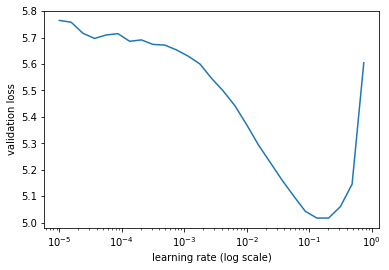

In [13]:
lrf=learn.lr_find(wds = 1e-1, use_wd_sched=True, start_lr=1e-05, end_lr=10)
learn.sched.plot(n_skip=0,n_skip_end=2)

In [14]:
#Use this to free more GPU memory after running training
torch.cuda.empty_cache()

In [ ]:
result, ep_vals = learn.fit(8e-2, 1, cycle_len=15, use_clr_beta=(10, 13.33), wds=1.2e-1, use_wd_sched=True, get_ep_vals=True)

  9%|▉         | 3/32 [00:16<03:40,  7.61s/it, loss=5.3] 

In [ ]:
learn.unfreeze()
torch.cuda.empty_cache()

In [ ]:
lrf=learn.lr_find(wds = 1e-1, use_wd_sched=True, start_lr=1e-06, end_lr=10)
learn.sched.plot(n_skip=0,n_skip_end=0)

In [ ]:
lr2 = 1e-3

In [ ]:
lrs = np.array([lr2/100,lr2/10,lr2])

In [ ]:
learn.fit(lrs, 1, cycle_len=40, use_clr_beta=(10, 10), wds=3e-3, use_wd_sched=True)

In [ ]:
log_preds, y = learn.TTA()

In [ ]:
probs = np.exp(log_preds)

In [ ]:
avg_TTA = np.mean(probs, axis = 0)

In [ ]:
preds = np.argmax(avg_TTA,axis=1)
targs = y

In [ ]:
TTA_acc = (preds==targs).mean()
print(TTA_acc)

In [ ]:
plt.hist(preds, bins=195)